In [1]:
import confirm.outlaw.nb_util as util

util.setup_nb()

In [2]:
import confirm.outlaw.berry as berry
import confirm.outlaw.quad as quad
import confirm.outlaw.inla as inla
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

## Run Outlaw hyperparameter posterior

In [3]:
dtype = np.float64
# data = berry.figure1_data(N=1)[0].astype(dtype)
data = berry.figure2_data(N=1)[0].astype(dtype)
sig2_rule = quad.log_gauss_rule(70, 1e-6, 1e3)
# sig2_rule = quad.log_gauss_rule(70, 1e-3, 1e3)
sig2 = sig2_rule.pts
# sig2_df = pd.DataFrame(dict(theta=sig2_rule.pts, wts=sig2_rule.wts))
# sig2_df.to_csv('sig2_rule.csv', index=False)

In [4]:
# data = berry.figure1_data(N=1)[0].astype(dtype)
# data

In [5]:
inla_ops = berry.optimized(sig2, dtype=dtype).config(max_iter=20, opt_tol=dtype(1e-9))

logpost, x_max, hess_info, iters = jax.jit(inla_ops.laplace_logpost)(
    np.zeros((sig2.shape[0], 4), dtype=dtype), dict(sig2=sig2), data
)
post = inla.exp_and_normalize(logpost, sig2_rule.wts.astype(dtype), axis=0)

In [6]:
arm_logpost_f = jax.jit(
    jax.vmap(
        inla_ops.cond_laplace_logpost,
        in_axes=(None, None, None, None, 0, None, None),
    ),
    static_argnums=(5, 6),
)
invv = jax.jit(jax.vmap(inla_ops.invert))

inv_hess = invv(hess_info)
arm_idx = 0
cx, wts = inla.gauss_hermite_grid(x_max, inv_hess[..., arm_idx, :], arm_idx, n=25)
# cx, wts = inla.latent_grid(
#     x_max, inv_hess[..., arm_idx, :], arm_idx,
#     quad.gauss_rule(105, a=-5, b=5)
# )
cx = cx[:, 0]
wts = wts[:, 0]

arm_logpost = arm_logpost_f(
    x_max, inv_hess[:, :, arm_idx], dict(sig2=sig2, theta=None), data, cx, arm_idx, True
)
arm_post = inla.exp_and_normalize(arm_logpost, wts, axis=0)
arm_quad = quad.simpson_rule(101, -15, 2)
# arm_quad = quad.simpson_rule(101, -4, 2)

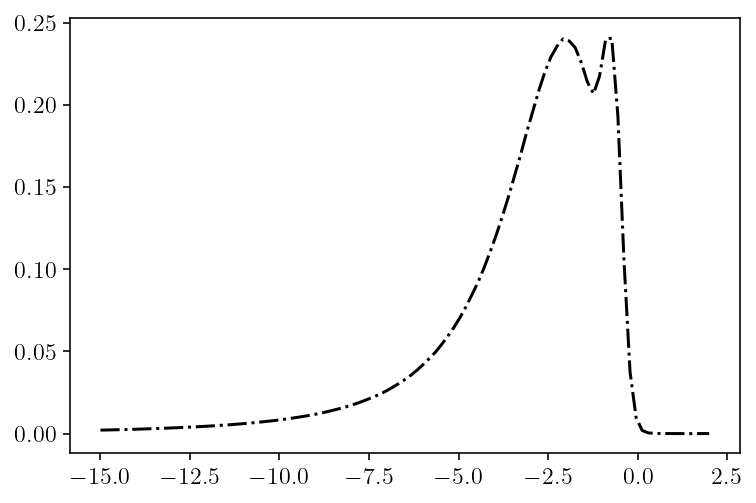

In [7]:
interp_vmap = jax.vmap(lambda *args: jnp.interp(*args, 0, 0), in_axes=(None, 1, 1))
interp_marg_condsig2 = interp_vmap(arm_quad.pts, cx, arm_post).T
uncon_pdf_interp = np.sum(interp_marg_condsig2 * post * sig2_rule.wts, axis=1)
plt.plot(arm_quad.pts, uncon_pdf_interp, "k-.")
plt.show()

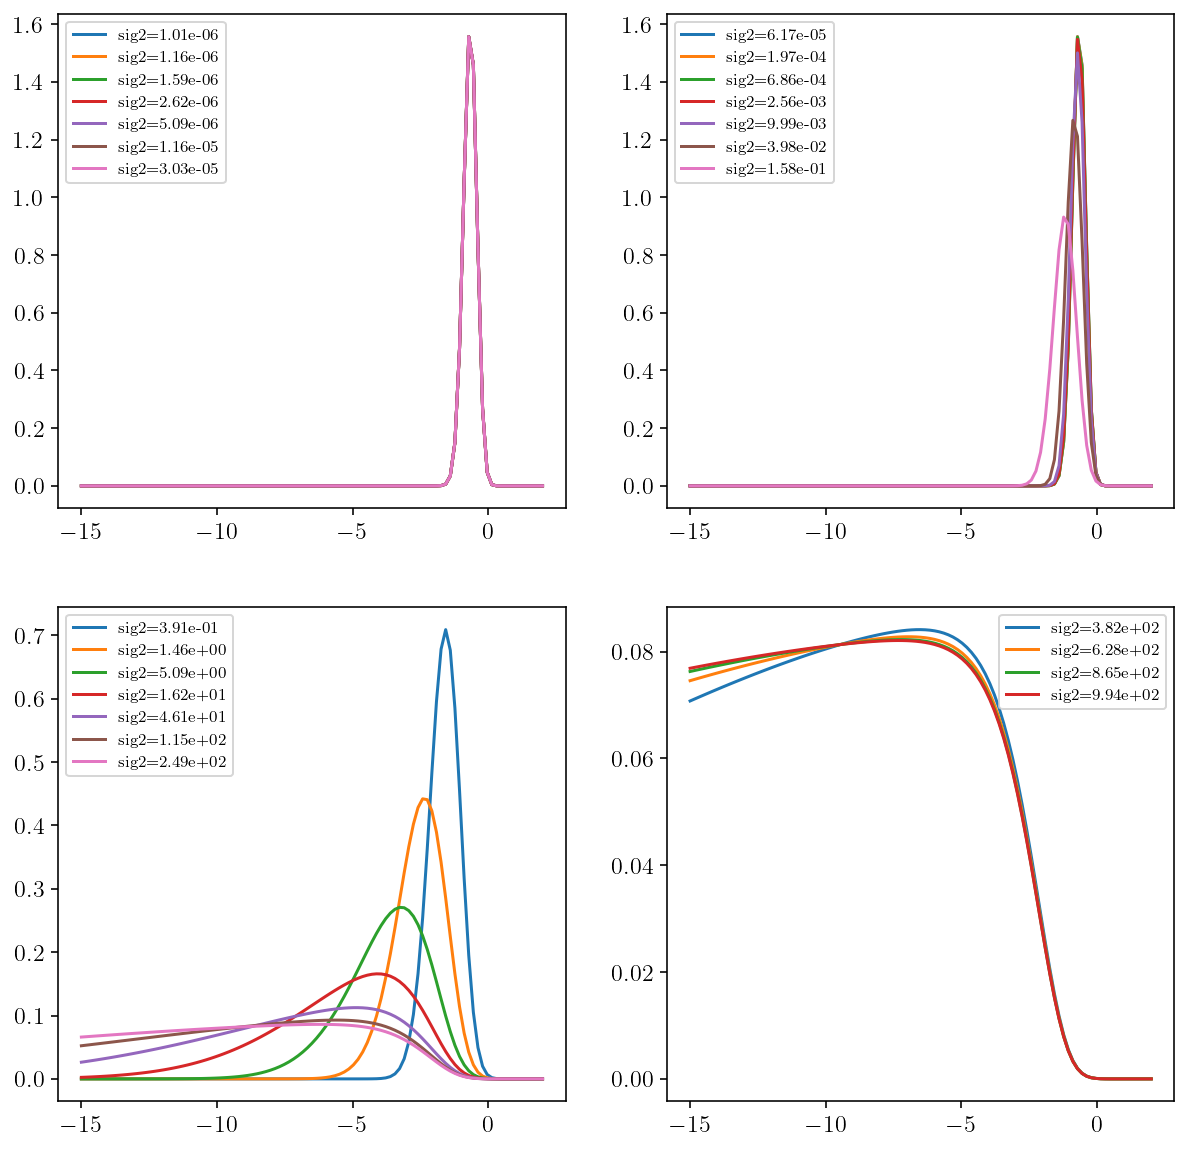

In [8]:
arm_idx = 0
inv_hess = jax.vmap(inla_ops.invert)(hess_info)

cx = np.tile(arm_quad.pts[:, None], (1, sig2.shape[0]))
wts = np.tile(arm_quad.wts[:, None], (1, sig2.shape[0]))
cond_laplace_f = jax.vmap(
    lambda *args: inla_ops.cond_laplace_logpost(*args, reduced=True),
    in_axes=(None, None, None, None, 0, None),
)
logpost_arm = cond_laplace_f(
    x_max, inv_hess[:, :, arm_idx], dict(sig2=sig2), data, cx, arm_idx
)
arm_post = inla.exp_and_normalize(logpost_arm, wts, axis=0)

group_size = 20
plt.figure(figsize=(10, 10))
for subplot_idx, i0 in enumerate(range(0, sig2_rule.pts.shape[0], group_size)):
    plt.subplot(2, 2, subplot_idx + 1)
    for i in range(i0, min(sig2_rule.pts.shape[0], i0 + group_size), 3):
        plt.plot(cx[:, i], arm_post[:, i], label="sig2={:.2e}".format(sig2_rule.pts[i]))
    plt.legend(fontsize=8)
    # plt.xlim([-10, 1])
plt.show()

In [9]:
theta_sigma = np.sqrt(np.diagonal(-inv_hess, axis1=1, axis2=2))
theta_mu = x_max
uncon_pdf_gaussian = np.sum(
    scipy.stats.norm.pdf(
        arm_quad.pts[:, None],
        theta_mu[None, :, arm_idx],
        theta_sigma[None, :, arm_idx],
    )
    * post
    * sig2_rule.wts,
    axis=1,
)

## Dirty Bayes

In [10]:
import confirm.berrylib.dirty_bayes as dirty_bayes

uncon_cdf_db = np.empty_like(uncon_pdf_interp)
for i, thresh in enumerate(arm_quad.pts):
    db_out = dirty_bayes.calc_dirty_bayes(
        np.where(data[None, ..., 0] == 0, 0.1, data[None, ..., 0]),
        data[None, ..., 1],
        berry.mu_0,
        berry.logit_p1,
        np.full((1, 4), thresh),
        sig2_rule,
    )
    uncon_cdf_db[i] = db_out["exceedance"][0, 0]
pdf = (uncon_cdf_db[2:] - uncon_cdf_db[:-2]) / (arm_quad.pts[2:] - arm_quad.pts[:-2])
uncon_pdf_db = -np.concatenate(([0], pdf, [0]))
uncon_pdf_db

array([-0.00000000e+00,  6.79466706e-07,  8.40762828e-07,  1.03777571e-06,  1.27779830e-06,
        1.56947425e-06,  1.92301908e-06,  2.35047198e-06,  2.86598157e-06,  3.48612899e-06,
        4.23029201e-06,  5.12105400e-06,  6.18466176e-06,  7.45153625e-06,  8.95684066e-06,
        1.07411099e-05,  1.28509465e-05,  1.53397867e-05,  1.82687419e-05,  2.17075204e-05,
        2.57354333e-05,  3.04424903e-05,  3.59305898e-05,  4.23148091e-05,  4.97247995e-05,
        5.83062926e-05,  6.82227246e-05,  7.96569847e-05,  9.28132975e-05,  1.07919247e-04,
        1.25227956e-04,  1.45020431e-04,  1.67608092e-04,  1.93335508e-04,  2.22583355e-04,
        2.55771633e-04,  2.93363181e-04,  3.35867514e-04,  3.83845061e-04,  4.37911848e-04,
        4.98744709e-04,  5.67087120e-04,  6.43755767e-04,  7.29647976e-04,  8.25750179e-04,
        9.33147597e-04,  1.05303538e-03,  1.18673150e-03,  1.33569169e-03,  1.50152690e-03,
        1.68602374e-03,  1.89116843e-03,  2.11917519e-03,  2.37251973e-03,  2.65

## Compare latent marginals

In [11]:
import confirm.berrylib.mcmc as mcmc

mcmc_results = mcmc.mcmc_berry(data[None], n_samples=int(1000000))

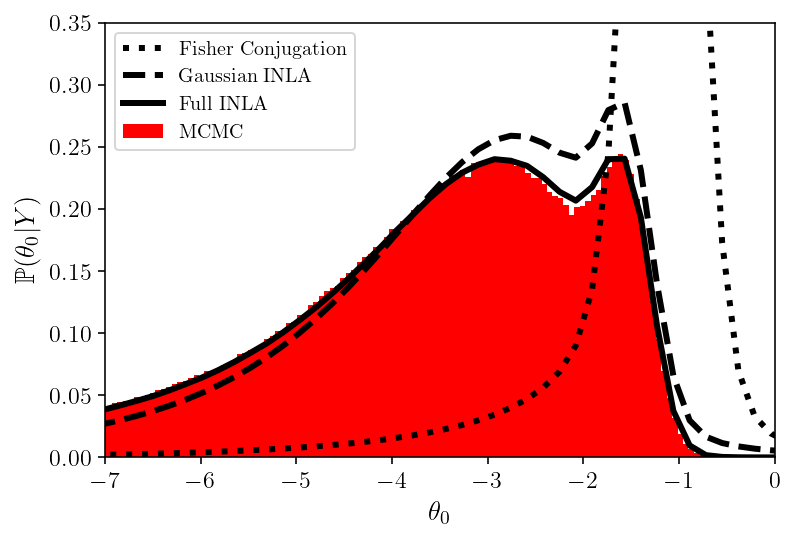

In [14]:
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_db,
    color="k",
    linestyle="dotted",
    linewidth=3,
    label="Fisher Conjugation",
)
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_gaussian,
    color="k",
    linestyle="dashed",
    linewidth=3,
    label="Gaussian INLA",
)
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_interp,
    color="k",
    linestyle="solid",
    linewidth=3,
    label="Full INLA",
)
plt.hist(
    mcmc_results["x"][0]["theta"][0, :, 0] + berry.logit_p1,
    bins=np.linspace(-15, 2, 300),
    color="red",
    density=True,
    label="MCMC",
)
plt.xlim([-7, 0])
plt.ylim([0, 0.35])
plt.legend(fontsize=10)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\mathbb{P}(\theta_0 | Y)$")
plt.savefig("inla_compare.png", dpi=300, bbox_inches="tight")
plt.show()

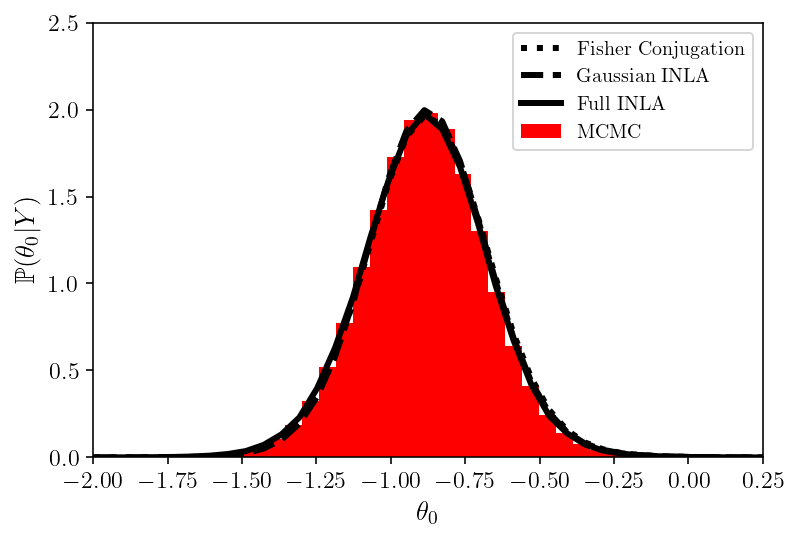

In [29]:
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_db,
    color="k",
    linestyle="dotted",
    linewidth=3,
    label="Fisher Conjugation",
)
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_gaussian,
    color="k",
    linestyle="dashed",
    linewidth=3,
    label="Gaussian INLA",
)
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_interp,
    color="k",
    linestyle="solid",
    linewidth=3,
    label="Full INLA",
)
plt.hist(
    mcmc_results["x"][0]["theta"][0, :, 0] + berry.logit_p1,
    bins=np.linspace(-15, 2, 300),
    color="red",
    density=True,
    label="MCMC",
)
plt.xlim([-2.0, 0.25])
plt.ylim([0, 2.5])
plt.legend(fontsize=10)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\mathbb{P}(\theta_0 | Y)$")
plt.show()